In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import pickle as pkl
from tensorflow import keras
import tensorflow.keras.backend as K
from keras.models import Sequential,Model
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, Input, Reshape, BatchNormalization, Bidirectional, LSTM, Multiply, Activation, Normalization, TimeDistributed
from keras.layers import Conv3D, Conv2D, Conv1D, MaxPool3D, MaxPool2D, MaxPool1D, AvgPool3D, AvgPool2D, AvgPool1D, GlobalMaxPool3D, Attention, Subtract
from keras.layers import GlobalMaxPool2D, GlobalMaxPool1D, SpatialDropout3D, SpatialDropout2D, SpatialDropout1D, GlobalAvgPool3D, MultiHeadAttention
from keras.layers import GlobalAvgPool2D, GlobalAvgPool1D, SeparableConv2D, SeparableConv1D, Add, Concatenate, LeakyReLU, ELU, Activation, PReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.utils import np_utils
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import gc

# **Data Loading**

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
gc.collect()

Mounted at /content/drive/


59

In [3]:
input_path='/content/drive/MyDrive/data_preprocessed_python/'

In [4]:
def baseline_remove(XR):
  XT = XR[:, 384:]
  XB_ = (XR[:, :1*128] + XR[:, 1*128:2*128] + XR[:, 2*128:3*128])/3.0
  for i in range(60):
    XT[:, i*128:(i+1)*128] = XT[:, i*128:(i+1)*128] - XB_
  return XT


In [5]:
new_channels = [0,1,18,2,3,5,4,23,6,7,9,8,15,10,11,12,14,13,
 16,17,18,19,20,22,21,23,24,25,27,26,15,28,29,30,14,31]

In [7]:
eeg_signal = []
valence = []
arousal = []
window_size = 256
no_channels = 32
no_new_channels = len(new_channels)
no_videos = 40
Trsld = 5

for person in range(5,6):
  print('Person No.' + str(person))
  
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<Trsld] = 0
  label[label>=Trsld] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(no_videos):
    sig = eeg[i][:no_channels, :]
    sig = baseline_remove(sig)
    temp = []
    for j in new_channels:
      temp.append(sig[j, :])
    sig = np.reshape(temp,[no_new_channels,-1])
    # Segmenting into 2 seconds (256 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      eeg_signal.append(sig[:, start:start+window_size])
      valence.append(val[i])
      arousal.append(aro[i])
      start += window_size 
  del eeg, val, aro, sig
eeg_signal = np.reshape(eeg_signal,[-1,no_new_channels,window_size,1])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
gc.collect()

Person No.5
(1200, 36, 256, 1)
(1200,) (480,) (720,)
(1200,) (630,) (570,)


0

In [8]:
def simple_2D_CNN(x): 
  x1 = Conv2D(filters = 32, kernel_size = (1,16), strides = (1,1), padding = 'same', activation='selu')(x) #above 8 Hz
  x2 = Conv2D(filters = 32, kernel_size = (1,10), strides = (1,1), padding = 'same', activation='selu')(x) #above 12.8 Hz
  x3 = Conv2D(filters = 32, kernel_size = (1,6), strides = (1,1), padding = 'same', activation='selu')(x) #above 21.3 Hz
  x1 = Subtract()([x1, x2]) #above 8 Hz and below 12.8 Hz
  x1 = MaxPool2D(pool_size=(1,2))(x1) #downsampling by 2
  x1 = Conv2D(filters = 32, kernel_size = (1,16), strides = (1,1), padding = 'same', activation='selu')(x1)
  x1 = MaxPool2D(pool_size=(1,2))(x1)
  x1 = Conv2D(filters = 32, kernel_size = (1,16), strides = (1,1), padding = 'same', activation='selu')(x1)
  x1 = MaxPool2D(pool_size=(1,2))(x1)
  x2 = Subtract()([x2, x3]) #above 12.8 Hz and below 21.3 Hz
  x2 = MaxPool2D(pool_size=(1,2))(x2)
  x2 = Conv2D(filters = 32, kernel_size = (1,10), strides = (1,1), padding = 'same', activation='selu')(x2)
  x2 = MaxPool2D(pool_size=(1,2))(x2)
  x2 = Conv2D(filters = 32, kernel_size = (1,10), strides = (1,1), padding = 'same', activation='selu')(x2)
  x2 = MaxPool2D(pool_size=(1,2))(x2)
  x = Concatenate(axis=3)([x1, x2])
  x = Dropout(0.1)(x)
  x1 = Conv2D(filters = 64, kernel_size = (2,4), strides = (2,1), padding = 'same', activation='selu')(x)
  x1 = Conv2D(filters = 64, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x1)
  x1 = Conv2D(filters = 64, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x1)
  x1 = MaxPool2D(pool_size=(1,2))(x1)
  x2 = Conv2D(filters = 64, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x)
  x2 = Conv2D(filters = 64, kernel_size = (2,4), strides = (2,1), padding = 'same', activation='selu')(x2)
  x2 = Conv2D(filters = 64, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x2)
  x2 = MaxPool2D(pool_size=(1,2))(x2)
  x3 = Conv2D(filters = 64, kernel_size = (6,4), strides = (6,1), padding = 'same', activation='selu')(x)
  x3 = Conv2D(filters = 64, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x3)
  x3 = MaxPool2D(pool_size=(1,2))(x3)
  x4 = Conv2D(filters = 64, kernel_size = (9,4), strides = (9,1), padding = 'same', activation='selu')(x)
  x4 = Conv2D(filters = 64, kernel_size = (2,4), strides = (2,1), padding = 'same', activation='selu')(x4)
  x4 = MaxPool2D(pool_size=(1,2))(x4)
  x5 = Conv2D(filters = 64, kernel_size = (18,4), strides = (18,1), padding = 'same', activation='selu')(x)
  x5 = MaxPool2D(pool_size=(1,2))(x5)
  x = Concatenate(axis=3)([x1, x2, x3, x4, x5])
  x = Dropout(0.1)(x)
  x = Conv2D(filters = x.shape[3], kernel_size = (2,2), strides = (2,1), padding = 'same', activation='selu')(x)
  x = GlobalAvgPool2D()(x)
  x = Dense(128, activation='tanh')(x)
  x = Dropout(0.1)(x)
  x = Dense(32, activation='relu')(x)
  x = Dropout(0.1)(x)
  x = Dense(2, activation='softmax')(x)
  return x

def get_model(): 
  input_shape = (data.shape[1], data.shape[2], 1) 
  a = Input(input_shape) 
  out = simple_2D_CNN(a) 
  model = Model(a, out) 
  opt = keras.optimizers.Adam(learning_rate=1e-04) 
  model.compile(loss=keras.losses.categorical_crossentropy, metrics=["accuracy"], optimizer=opt) 
  return model 
model = get_model() 
model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 36, 256, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 36, 256, 32)  544         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 36, 256, 32)  352         ['input_1[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 36, 256, 32)  224         ['input_1[0][0]']            

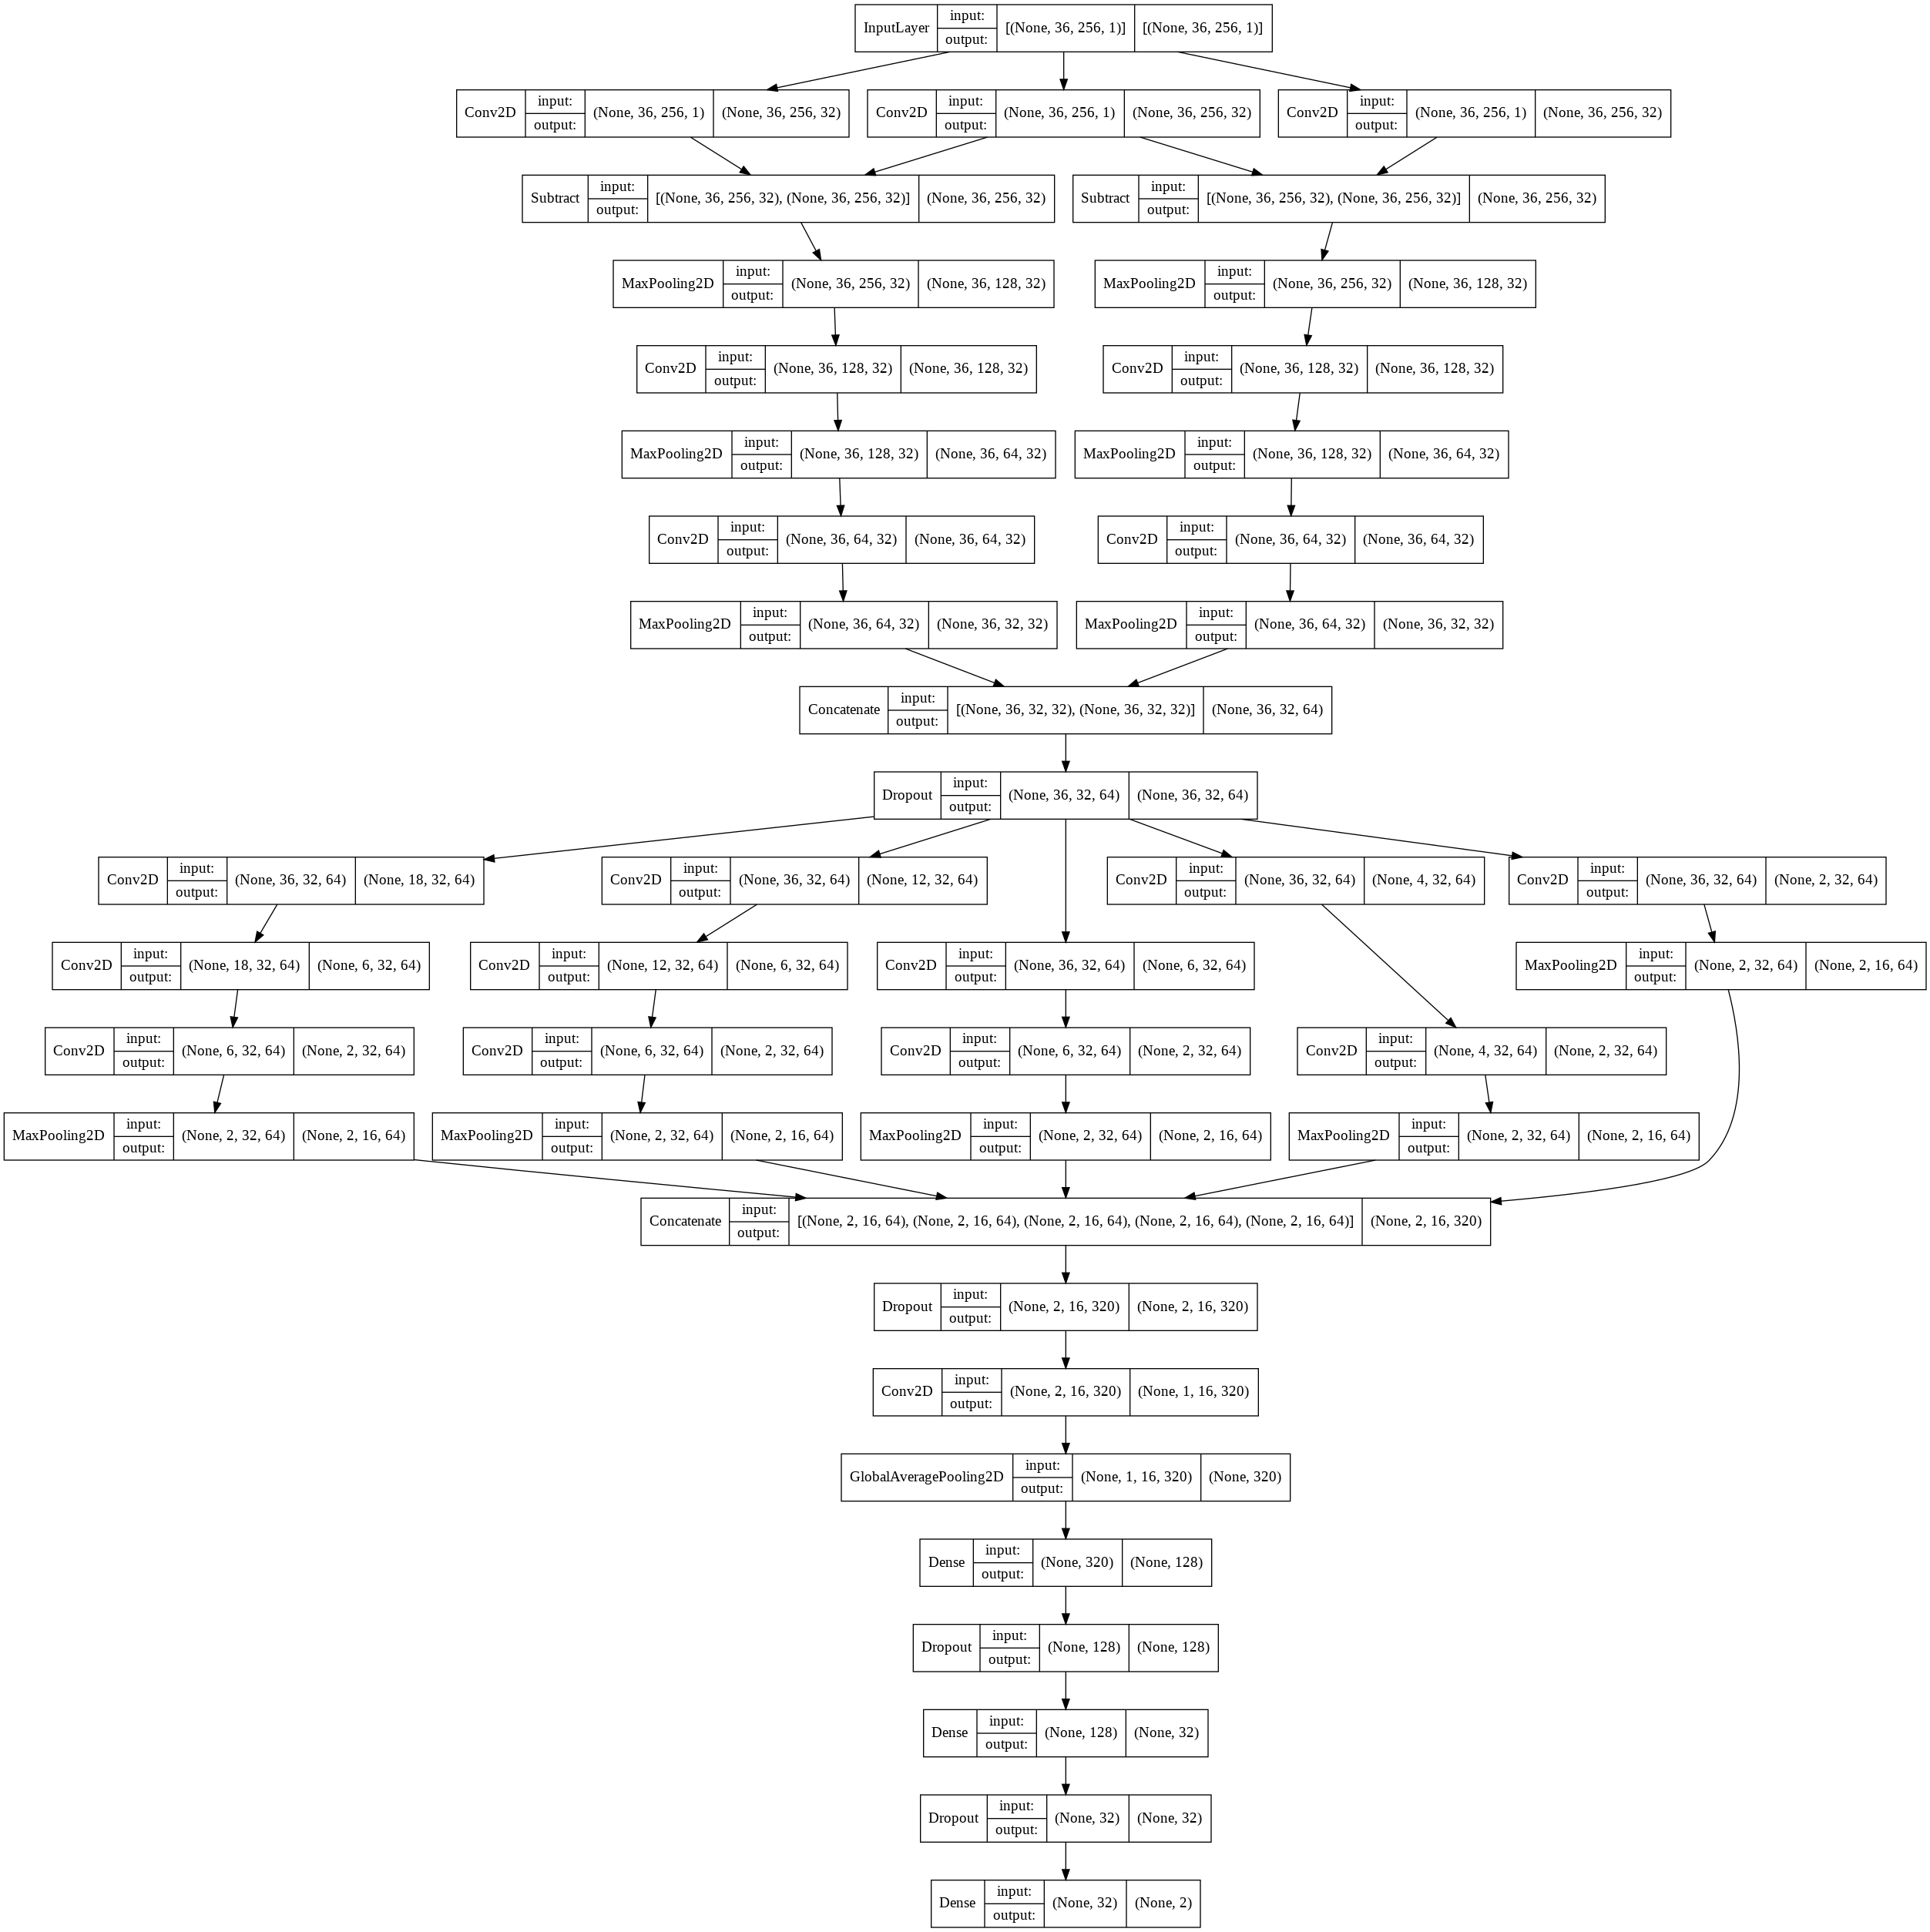

In [9]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

In [10]:
batch_size = 64
epochs = 50
kfold = KFold(n_splits=10, random_state=1, shuffle=True)
gc.collect()

13666

In [11]:
def call_class_weights(yt):
  y_integers = np.argmax(yt, axis=1)
  class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y_integers), y = y_integers)
  d_class_weights = dict(enumerate(class_weights))
  return d_class_weights

# **Valence**

In [12]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data, valence, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 36, 256, 1) (120, 36, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/50
16/16 [==============================] - 16s 184ms/step - loss: 0.7373 - accuracy: 0.5165 - val_loss: 0.6616 - val_accuracy: 0.7130
Epoch 2/50
16/16 [==============================] - 2s 100ms/step - loss: 0.6881 - accuracy: 0.5237 - val_loss: 0.6502 - val_accuracy: 0.7315
Epoch 3/50
16/16 [==============================] - 2s 100ms/step - loss: 0.6830 - accuracy: 0.5566 - val_loss: 0.6174 - val_accuracy: 0.6944
Epoch 4/50
16/16 [==============================] - 2s 100ms/step - loss: 0.6574 - accuracy: 0.6214 - val_loss: 0.6252 - val_accuracy: 0.7222
Epoch 5/50
16/16 [==============================] - 2s 100ms/step - loss: 0.6555 - accuracy: 0.5998 - val_loss: 0.6828 - val_accuracy: 0.4815
Epoch 6/50
16/16 [==============================] - 2s 101ms/step - loss: 0.6654 - accuracy: 0.5988 - val_loss: 0.6786 - val_accuracy: 0.4259
Epoch 7/50
16/16 [==============================] - 2s 100ms/step - loss: 0.6677 - accuracy: 0.5607 - val_loss: 0.5962 - val_acc

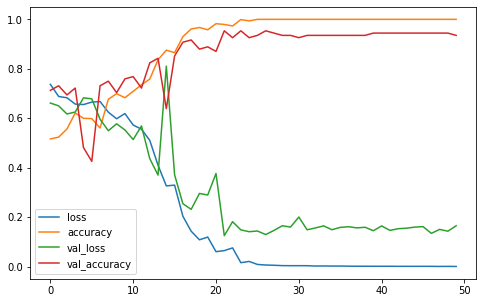

Results for fold 2
Epoch 1/50
16/16 [==============================] - 3s 123ms/step - loss: 0.7842 - accuracy: 0.5422 - val_loss: 0.7037 - val_accuracy: 0.4630
Epoch 2/50
16/16 [==============================] - 2s 102ms/step - loss: 0.6727 - accuracy: 0.6060 - val_loss: 0.6078 - val_accuracy: 0.6574
Epoch 3/50
16/16 [==============================] - 2s 102ms/step - loss: 0.6682 - accuracy: 0.6019 - val_loss: 0.6358 - val_accuracy: 0.7500
Epoch 4/50
16/16 [==============================] - 2s 102ms/step - loss: 0.6427 - accuracy: 0.6358 - val_loss: 0.5896 - val_accuracy: 0.7222
Epoch 5/50
16/16 [==============================] - 2s 103ms/step - loss: 0.6578 - accuracy: 0.6255 - val_loss: 0.5902 - val_accuracy: 0.7037
Epoch 6/50
16/16 [==============================] - 2s 104ms/step - loss: 0.5697 - accuracy: 0.7171 - val_loss: 0.6041 - val_accuracy: 0.6389
Epoch 7/50
16/16 [==============================] - 2s 103ms/step - loss: 0.5423 - accuracy: 0.7253 - val_loss: 0.4729 - val_accu

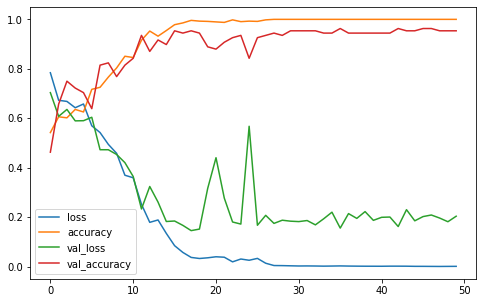

Results for fold 3
Epoch 1/50
16/16 [==============================] - 3s 128ms/step - loss: 0.7376 - accuracy: 0.4846 - val_loss: 0.6935 - val_accuracy: 0.5093
Epoch 2/50
16/16 [==============================] - 2s 106ms/step - loss: 0.6820 - accuracy: 0.5514 - val_loss: 0.6768 - val_accuracy: 0.6667
Epoch 3/50
16/16 [==============================] - 2s 107ms/step - loss: 0.6792 - accuracy: 0.5432 - val_loss: 0.7161 - val_accuracy: 0.4722
Epoch 4/50
16/16 [==============================] - 2s 107ms/step - loss: 0.6844 - accuracy: 0.5556 - val_loss: 0.6457 - val_accuracy: 0.7130
Epoch 5/50
16/16 [==============================] - 2s 107ms/step - loss: 0.6523 - accuracy: 0.6358 - val_loss: 0.6586 - val_accuracy: 0.6481
Epoch 6/50
16/16 [==============================] - 2s 107ms/step - loss: 0.6456 - accuracy: 0.6276 - val_loss: 0.6304 - val_accuracy: 0.6852
Epoch 7/50
16/16 [==============================] - 2s 107ms/step - loss: 0.6196 - accuracy: 0.6872 - val_loss: 0.6338 - val_accu

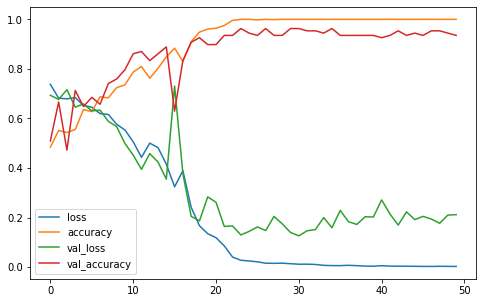

Results for fold 4
Epoch 1/50
16/16 [==============================] - 3s 130ms/step - loss: 0.7196 - accuracy: 0.5051 - val_loss: 0.6993 - val_accuracy: 0.4352
Epoch 2/50
16/16 [==============================] - 2s 108ms/step - loss: 0.6867 - accuracy: 0.5442 - val_loss: 0.6216 - val_accuracy: 0.7037
Epoch 3/50
16/16 [==============================] - 2s 108ms/step - loss: 0.6610 - accuracy: 0.5895 - val_loss: 0.6011 - val_accuracy: 0.7593
Epoch 4/50
16/16 [==============================] - 2s 108ms/step - loss: 0.6473 - accuracy: 0.6379 - val_loss: 0.5770 - val_accuracy: 0.7870
Epoch 5/50
16/16 [==============================] - 2s 108ms/step - loss: 0.6303 - accuracy: 0.6759 - val_loss: 0.5432 - val_accuracy: 0.8148
Epoch 6/50
16/16 [==============================] - 2s 108ms/step - loss: 0.6034 - accuracy: 0.7016 - val_loss: 0.4870 - val_accuracy: 0.8241
Epoch 7/50
16/16 [==============================] - 2s 108ms/step - loss: 0.5811 - accuracy: 0.6934 - val_loss: 0.4914 - val_accu

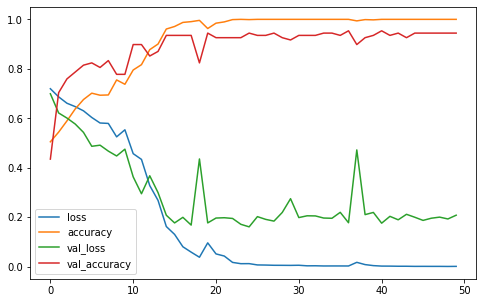

Results for fold 5
Epoch 1/50
16/16 [==============================] - 3s 128ms/step - loss: 0.8032 - accuracy: 0.5031 - val_loss: 0.6795 - val_accuracy: 0.5833
Epoch 2/50
16/16 [==============================] - 2s 106ms/step - loss: 0.7061 - accuracy: 0.5391 - val_loss: 0.7002 - val_accuracy: 0.4074
Epoch 3/50
16/16 [==============================] - 2s 106ms/step - loss: 0.6922 - accuracy: 0.5566 - val_loss: 0.6405 - val_accuracy: 0.6667
Epoch 4/50
16/16 [==============================] - 2s 106ms/step - loss: 0.7415 - accuracy: 0.5669 - val_loss: 0.6791 - val_accuracy: 0.6296
Epoch 5/50
16/16 [==============================] - 2s 107ms/step - loss: 0.6959 - accuracy: 0.5484 - val_loss: 0.7066 - val_accuracy: 0.4630
Epoch 6/50
16/16 [==============================] - 2s 107ms/step - loss: 0.6697 - accuracy: 0.5720 - val_loss: 0.6333 - val_accuracy: 0.6574
Epoch 7/50
16/16 [==============================] - 2s 106ms/step - loss: 0.7003 - accuracy: 0.5844 - val_loss: 0.6843 - val_accu

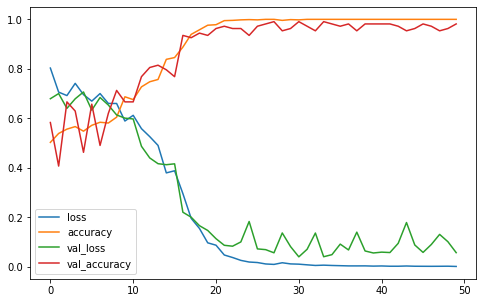

Results for fold 6
Epoch 1/50
16/16 [==============================] - 3s 129ms/step - loss: 0.7941 - accuracy: 0.5298 - val_loss: 0.7087 - val_accuracy: 0.4630
Epoch 2/50
16/16 [==============================] - 2s 109ms/step - loss: 0.6793 - accuracy: 0.5844 - val_loss: 0.6473 - val_accuracy: 0.6296
Epoch 3/50
16/16 [==============================] - 2s 108ms/step - loss: 0.6751 - accuracy: 0.5679 - val_loss: 0.6552 - val_accuracy: 0.6296
Epoch 4/50
16/16 [==============================] - 2s 108ms/step - loss: 0.6495 - accuracy: 0.6163 - val_loss: 0.6338 - val_accuracy: 0.6019
Epoch 5/50
16/16 [==============================] - 2s 109ms/step - loss: 0.6259 - accuracy: 0.6595 - val_loss: 0.6273 - val_accuracy: 0.6574
Epoch 6/50
16/16 [==============================] - 2s 108ms/step - loss: 0.6170 - accuracy: 0.6646 - val_loss: 0.6273 - val_accuracy: 0.6759
Epoch 7/50
16/16 [==============================] - 2s 109ms/step - loss: 0.6092 - accuracy: 0.6759 - val_loss: 0.6491 - val_accu

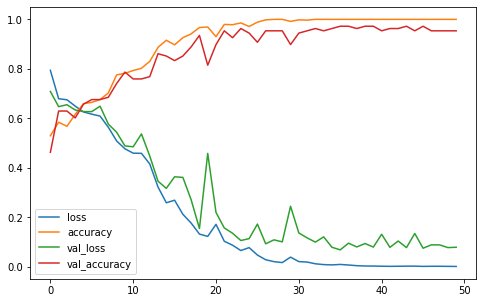

Results for fold 7
Epoch 1/50
16/16 [==============================] - 3s 127ms/step - loss: 0.7661 - accuracy: 0.5309 - val_loss: 0.6729 - val_accuracy: 0.5556
Epoch 2/50
16/16 [==============================] - 2s 107ms/step - loss: 0.7210 - accuracy: 0.5360 - val_loss: 0.6928 - val_accuracy: 0.5093
Epoch 3/50
16/16 [==============================] - 2s 107ms/step - loss: 0.6792 - accuracy: 0.5679 - val_loss: 0.7436 - val_accuracy: 0.4444
Epoch 4/50
16/16 [==============================] - 2s 108ms/step - loss: 0.7075 - accuracy: 0.5031 - val_loss: 0.6940 - val_accuracy: 0.4907
Epoch 5/50
16/16 [==============================] - 2s 108ms/step - loss: 0.6913 - accuracy: 0.5556 - val_loss: 0.6641 - val_accuracy: 0.6389
Epoch 6/50
16/16 [==============================] - 2s 107ms/step - loss: 0.6915 - accuracy: 0.5545 - val_loss: 0.6398 - val_accuracy: 0.6389
Epoch 7/50
16/16 [==============================] - 2s 107ms/step - loss: 0.6735 - accuracy: 0.5998 - val_loss: 0.6770 - val_accu

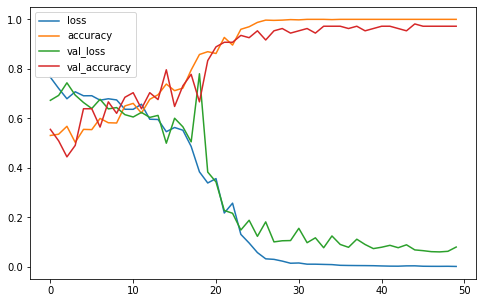

Results for fold 8
Epoch 1/50
16/16 [==============================] - 3s 129ms/step - loss: 0.7260 - accuracy: 0.4979 - val_loss: 0.6814 - val_accuracy: 0.5648
Epoch 2/50
16/16 [==============================] - 2s 108ms/step - loss: 0.6783 - accuracy: 0.5669 - val_loss: 0.6299 - val_accuracy: 0.7407
Epoch 3/50
16/16 [==============================] - 2s 108ms/step - loss: 0.6523 - accuracy: 0.6193 - val_loss: 0.5966 - val_accuracy: 0.7315
Epoch 4/50
16/16 [==============================] - 2s 108ms/step - loss: 0.6274 - accuracy: 0.6646 - val_loss: 0.6897 - val_accuracy: 0.5278
Epoch 5/50
16/16 [==============================] - 2s 108ms/step - loss: 0.6414 - accuracy: 0.6358 - val_loss: 0.5919 - val_accuracy: 0.7685
Epoch 6/50
16/16 [==============================] - 2s 108ms/step - loss: 0.6016 - accuracy: 0.6728 - val_loss: 0.5193 - val_accuracy: 0.7870
Epoch 7/50
16/16 [==============================] - 2s 108ms/step - loss: 0.5993 - accuracy: 0.6626 - val_loss: 0.4834 - val_accu

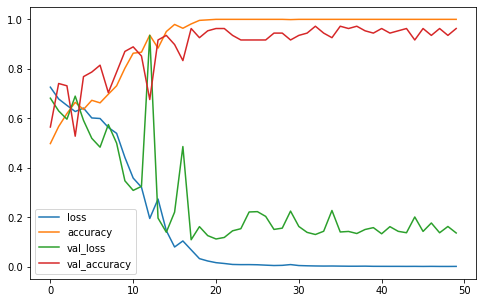

Results for fold 9
Epoch 1/50
16/16 [==============================] - 3s 128ms/step - loss: 0.7443 - accuracy: 0.5319 - val_loss: 0.7263 - val_accuracy: 0.4074
Epoch 2/50
16/16 [==============================] - 2s 108ms/step - loss: 0.6973 - accuracy: 0.5267 - val_loss: 0.6912 - val_accuracy: 0.4444
Epoch 3/50
16/16 [==============================] - 2s 107ms/step - loss: 0.6819 - accuracy: 0.5597 - val_loss: 0.6441 - val_accuracy: 0.6944
Epoch 4/50
16/16 [==============================] - 2s 108ms/step - loss: 0.6449 - accuracy: 0.6101 - val_loss: 0.6979 - val_accuracy: 0.5278
Epoch 5/50
16/16 [==============================] - 2s 108ms/step - loss: 0.6425 - accuracy: 0.6019 - val_loss: 0.6094 - val_accuracy: 0.7222
Epoch 6/50
16/16 [==============================] - 2s 107ms/step - loss: 0.6236 - accuracy: 0.6060 - val_loss: 0.6312 - val_accuracy: 0.6389
Epoch 7/50
16/16 [==============================] - 2s 107ms/step - loss: 0.5726 - accuracy: 0.7047 - val_loss: 0.7920 - val_accu

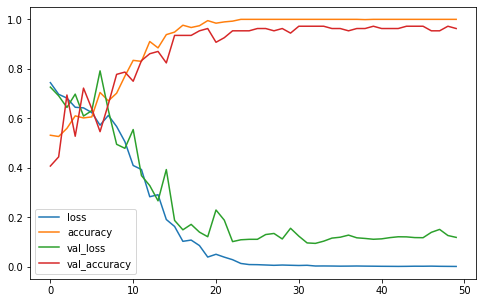

Results for fold 10
Epoch 1/50
16/16 [==============================] - 3s 126ms/step - loss: 0.7101 - accuracy: 0.5442 - val_loss: 0.6635 - val_accuracy: 0.6481
Epoch 2/50
16/16 [==============================] - 2s 108ms/step - loss: 0.6885 - accuracy: 0.5463 - val_loss: 0.6905 - val_accuracy: 0.5185
Epoch 3/50
16/16 [==============================] - 2s 108ms/step - loss: 0.6340 - accuracy: 0.6235 - val_loss: 0.6167 - val_accuracy: 0.6667
Epoch 4/50
16/16 [==============================] - 2s 108ms/step - loss: 0.6294 - accuracy: 0.6780 - val_loss: 0.5853 - val_accuracy: 0.7222
Epoch 5/50
16/16 [==============================] - 2s 108ms/step - loss: 0.6194 - accuracy: 0.6667 - val_loss: 0.5740 - val_accuracy: 0.7222
Epoch 6/50
16/16 [==============================] - 2s 108ms/step - loss: 0.5672 - accuracy: 0.7325 - val_loss: 0.5679 - val_accuracy: 0.7130
Epoch 7/50
16/16 [==============================] - 2s 107ms/step - loss: 0.5681 - accuracy: 0.7222 - val_loss: 0.6083 - val_acc

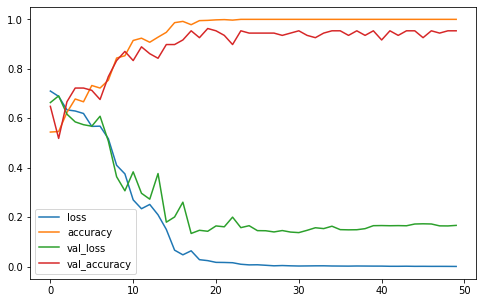

In [13]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9800000071525574
F1_Score  : 0.9792497489149861


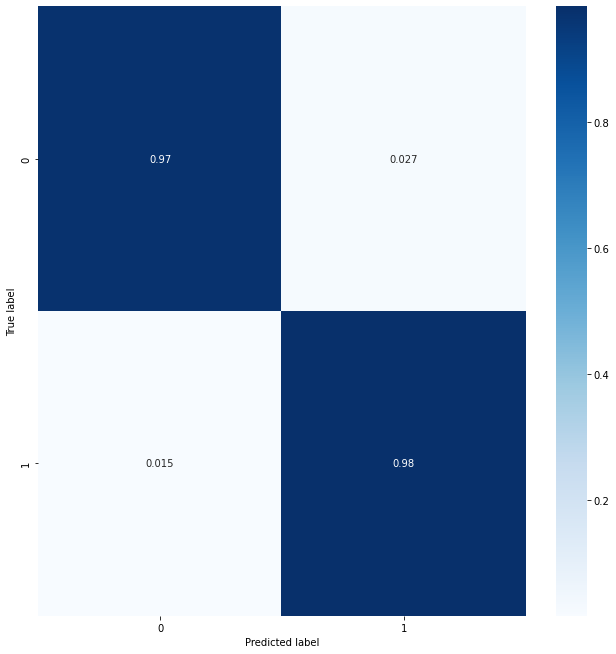

In [14]:
#50 epochs
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [15]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 36, 256, 1) (120, 36, 256, 1) (1080, 2) (120, 2)


Results for fold 1
Epoch 1/50
16/16 [==============================] - 3s 127ms/step - loss: 0.7577 - accuracy: 0.4733 - val_loss: 0.6804 - val_accuracy: 0.6204
Epoch 2/50
16/16 [==============================] - 2s 105ms/step - loss: 0.7004 - accuracy: 0.5360 - val_loss: 0.6972 - val_accuracy: 0.4352
Epoch 3/50
16/16 [==============================] - 2s 106ms/step - loss: 0.7067 - accuracy: 0.4979 - val_loss: 0.6906 - val_accuracy: 0.4630
Epoch 4/50
16/16 [==============================] - 2s 105ms/step - loss: 0.6953 - accuracy: 0.5319 - val_loss: 0.6817 - val_accuracy: 0.6019
Epoch 5/50
16/16 [==============================] - 2s 106ms/step - loss: 0.6940 - accuracy: 0.5391 - val_loss: 0.6788 - val_accuracy: 0.7407
Epoch 6/50
16/16 [==============================] - 2s 106ms/step - loss: 0.7091 - accuracy: 0.4877 - val_loss: 0.6945 - val_accuracy: 0.4352
Epoch 7/50
16/16 [==============================] - 2s 107ms/step - loss: 0.6995 - accuracy: 0.5072 - val_loss: 0.6629 - val_accu

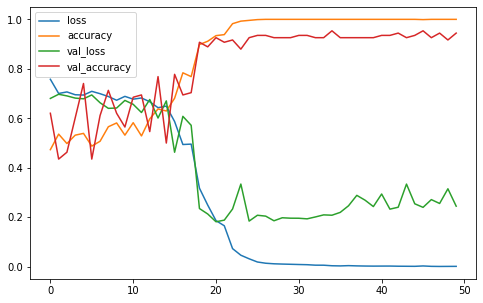

Results for fold 2
Epoch 1/50
16/16 [==============================] - 3s 126ms/step - loss: 0.7859 - accuracy: 0.4897 - val_loss: 0.6909 - val_accuracy: 0.5556
Epoch 2/50
16/16 [==============================] - 2s 106ms/step - loss: 0.7077 - accuracy: 0.5113 - val_loss: 0.6981 - val_accuracy: 0.4444
Epoch 3/50
16/16 [==============================] - 2s 106ms/step - loss: 0.6932 - accuracy: 0.5422 - val_loss: 0.6887 - val_accuracy: 0.5556
Epoch 4/50
16/16 [==============================] - 2s 107ms/step - loss: 0.7084 - accuracy: 0.5165 - val_loss: 0.6846 - val_accuracy: 0.5556
Epoch 5/50
16/16 [==============================] - 2s 106ms/step - loss: 0.6965 - accuracy: 0.5062 - val_loss: 0.6815 - val_accuracy: 0.5648
Epoch 6/50
16/16 [==============================] - 2s 107ms/step - loss: 0.7013 - accuracy: 0.5319 - val_loss: 0.6840 - val_accuracy: 0.5741
Epoch 7/50
16/16 [==============================] - 2s 107ms/step - loss: 0.6925 - accuracy: 0.5401 - val_loss: 0.6871 - val_accu

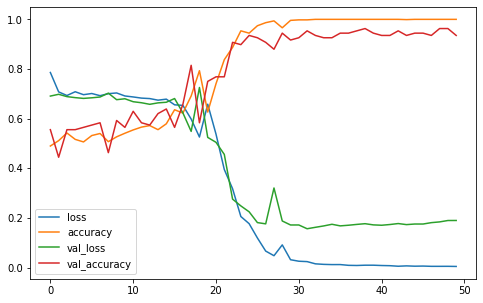

Results for fold 3
Epoch 1/50
16/16 [==============================] - 3s 125ms/step - loss: 0.8311 - accuracy: 0.5072 - val_loss: 0.7077 - val_accuracy: 0.4815
Epoch 2/50
16/16 [==============================] - 2s 106ms/step - loss: 0.7411 - accuracy: 0.5010 - val_loss: 0.6918 - val_accuracy: 0.5278
Epoch 3/50
16/16 [==============================] - 2s 106ms/step - loss: 0.7346 - accuracy: 0.5010 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 4/50
16/16 [==============================] - 2s 106ms/step - loss: 0.7079 - accuracy: 0.5093 - val_loss: 0.7193 - val_accuracy: 0.4815
Epoch 5/50
16/16 [==============================] - 2s 107ms/step - loss: 0.7063 - accuracy: 0.5350 - val_loss: 0.6861 - val_accuracy: 0.5556
Epoch 6/50
16/16 [==============================] - 2s 107ms/step - loss: 0.6851 - accuracy: 0.5741 - val_loss: 0.6674 - val_accuracy: 0.5741
Epoch 7/50
16/16 [==============================] - 2s 107ms/step - loss: 0.6767 - accuracy: 0.5720 - val_loss: 0.6503 - val_accu

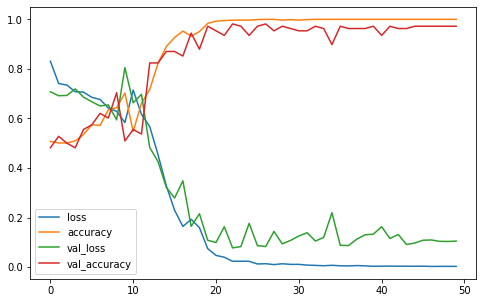

Results for fold 4
Epoch 1/50
16/16 [==============================] - 3s 125ms/step - loss: 0.7805 - accuracy: 0.4918 - val_loss: 0.7228 - val_accuracy: 0.4444
Epoch 2/50
16/16 [==============================] - 2s 105ms/step - loss: 0.7020 - accuracy: 0.4815 - val_loss: 0.7113 - val_accuracy: 0.4444
Epoch 3/50
16/16 [==============================] - 2s 106ms/step - loss: 0.7032 - accuracy: 0.4856 - val_loss: 0.7077 - val_accuracy: 0.4444
Epoch 4/50
16/16 [==============================] - 2s 106ms/step - loss: 0.7108 - accuracy: 0.4856 - val_loss: 0.7074 - val_accuracy: 0.4444
Epoch 5/50
16/16 [==============================] - 2s 106ms/step - loss: 0.7092 - accuracy: 0.5103 - val_loss: 0.6925 - val_accuracy: 0.5370
Epoch 6/50
16/16 [==============================] - 2s 106ms/step - loss: 0.6981 - accuracy: 0.5021 - val_loss: 0.6981 - val_accuracy: 0.4444
Epoch 7/50
16/16 [==============================] - 2s 107ms/step - loss: 0.6947 - accuracy: 0.5309 - val_loss: 0.6875 - val_accu

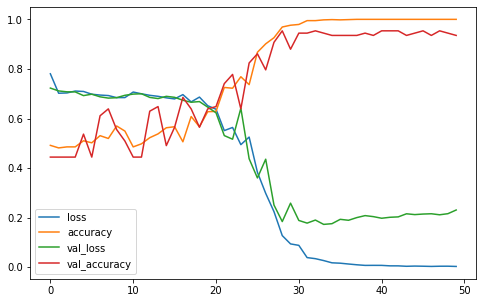

Results for fold 5
Epoch 1/50
16/16 [==============================] - 3s 127ms/step - loss: 0.8723 - accuracy: 0.4990 - val_loss: 0.6910 - val_accuracy: 0.5741
Epoch 2/50
16/16 [==============================] - 2s 106ms/step - loss: 0.7068 - accuracy: 0.5545 - val_loss: 0.6808 - val_accuracy: 0.5185
Epoch 3/50
16/16 [==============================] - 2s 107ms/step - loss: 0.6931 - accuracy: 0.5381 - val_loss: 0.6836 - val_accuracy: 0.5370
Epoch 4/50
16/16 [==============================] - 2s 107ms/step - loss: 0.6970 - accuracy: 0.5484 - val_loss: 0.6781 - val_accuracy: 0.5833
Epoch 5/50
16/16 [==============================] - 2s 107ms/step - loss: 0.6927 - accuracy: 0.5576 - val_loss: 0.6916 - val_accuracy: 0.5278
Epoch 6/50
16/16 [==============================] - 2s 106ms/step - loss: 0.7079 - accuracy: 0.4928 - val_loss: 0.6935 - val_accuracy: 0.4722
Epoch 7/50
16/16 [==============================] - 2s 107ms/step - loss: 0.7017 - accuracy: 0.4938 - val_loss: 0.6898 - val_accu

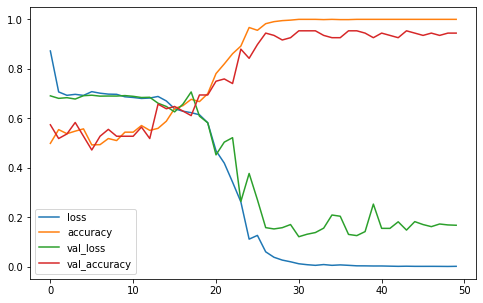

Results for fold 6
Epoch 1/50
16/16 [==============================] - 3s 128ms/step - loss: 0.7539 - accuracy: 0.4959 - val_loss: 0.6876 - val_accuracy: 0.5741
Epoch 2/50
16/16 [==============================] - 2s 107ms/step - loss: 0.6952 - accuracy: 0.4938 - val_loss: 0.6868 - val_accuracy: 0.6574
Epoch 3/50
16/16 [==============================] - 2s 107ms/step - loss: 0.6957 - accuracy: 0.5123 - val_loss: 0.6883 - val_accuracy: 0.6852
Epoch 4/50
16/16 [==============================] - 2s 107ms/step - loss: 0.6935 - accuracy: 0.4949 - val_loss: 0.6909 - val_accuracy: 0.6574
Epoch 5/50
16/16 [==============================] - 2s 108ms/step - loss: 0.6875 - accuracy: 0.5689 - val_loss: 0.6919 - val_accuracy: 0.4907
Epoch 6/50
16/16 [==============================] - 2s 108ms/step - loss: 0.6821 - accuracy: 0.5535 - val_loss: 0.6893 - val_accuracy: 0.4907
Epoch 7/50
16/16 [==============================] - 2s 108ms/step - loss: 0.6855 - accuracy: 0.5432 - val_loss: 0.6665 - val_accu

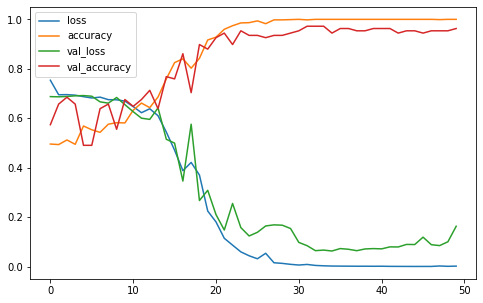

Results for fold 7
Epoch 1/50
16/16 [==============================] - 3s 125ms/step - loss: 0.7918 - accuracy: 0.5329 - val_loss: 0.6746 - val_accuracy: 0.5741
Epoch 2/50
16/16 [==============================] - 2s 106ms/step - loss: 0.6968 - accuracy: 0.5422 - val_loss: 0.6584 - val_accuracy: 0.6481
Epoch 3/50
16/16 [==============================] - 2s 106ms/step - loss: 0.6732 - accuracy: 0.5802 - val_loss: 0.6423 - val_accuracy: 0.6296
Epoch 4/50
16/16 [==============================] - 2s 106ms/step - loss: 0.6651 - accuracy: 0.5936 - val_loss: 0.6569 - val_accuracy: 0.5463
Epoch 5/50
16/16 [==============================] - 2s 107ms/step - loss: 0.6446 - accuracy: 0.6132 - val_loss: 0.6306 - val_accuracy: 0.6574
Epoch 6/50
16/16 [==============================] - 2s 107ms/step - loss: 0.6174 - accuracy: 0.6574 - val_loss: 0.6323 - val_accuracy: 0.5926
Epoch 7/50
16/16 [==============================] - 2s 107ms/step - loss: 0.5661 - accuracy: 0.7088 - val_loss: 0.5472 - val_accu

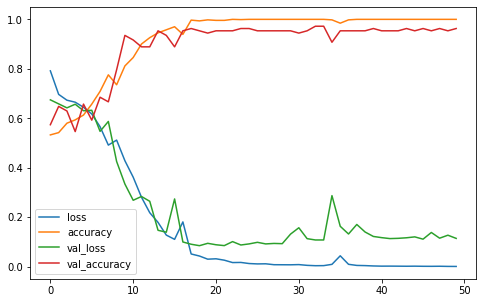

Results for fold 8
Epoch 1/50
16/16 [==============================] - 3s 129ms/step - loss: 0.7545 - accuracy: 0.5123 - val_loss: 0.6666 - val_accuracy: 0.5093
Epoch 2/50
16/16 [==============================] - 2s 106ms/step - loss: 0.7099 - accuracy: 0.5093 - val_loss: 0.6862 - val_accuracy: 0.5463
Epoch 3/50
16/16 [==============================] - 2s 107ms/step - loss: 0.7095 - accuracy: 0.5103 - val_loss: 0.6805 - val_accuracy: 0.5463
Epoch 4/50
16/16 [==============================] - 2s 107ms/step - loss: 0.7029 - accuracy: 0.5051 - val_loss: 0.6662 - val_accuracy: 0.6019
Epoch 5/50
16/16 [==============================] - 2s 108ms/step - loss: 0.6928 - accuracy: 0.5391 - val_loss: 0.6623 - val_accuracy: 0.5926
Epoch 6/50
16/16 [==============================] - 2s 107ms/step - loss: 0.6826 - accuracy: 0.5700 - val_loss: 0.6566 - val_accuracy: 0.6759
Epoch 7/50
16/16 [==============================] - 2s 108ms/step - loss: 0.6773 - accuracy: 0.5669 - val_loss: 0.6482 - val_accu

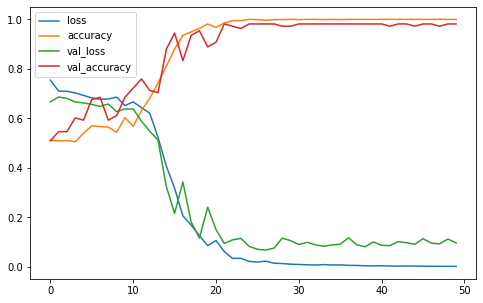

Results for fold 9
Epoch 1/50
16/16 [==============================] - 3s 127ms/step - loss: 0.7723 - accuracy: 0.5185 - val_loss: 0.6888 - val_accuracy: 0.5370
Epoch 2/50
16/16 [==============================] - 2s 108ms/step - loss: 0.7172 - accuracy: 0.5144 - val_loss: 0.6915 - val_accuracy: 0.4722
Epoch 3/50
16/16 [==============================] - 2s 107ms/step - loss: 0.7082 - accuracy: 0.5412 - val_loss: 0.6788 - val_accuracy: 0.6111
Epoch 4/50
16/16 [==============================] - 2s 108ms/step - loss: 0.7121 - accuracy: 0.5144 - val_loss: 0.6888 - val_accuracy: 0.4630
Epoch 5/50
16/16 [==============================] - 2s 107ms/step - loss: 0.7197 - accuracy: 0.5082 - val_loss: 0.6888 - val_accuracy: 0.4630
Epoch 6/50
16/16 [==============================] - 2s 107ms/step - loss: 0.7101 - accuracy: 0.5134 - val_loss: 0.6992 - val_accuracy: 0.4630
Epoch 7/50
16/16 [==============================] - 2s 108ms/step - loss: 0.7113 - accuracy: 0.4959 - val_loss: 0.6782 - val_accu

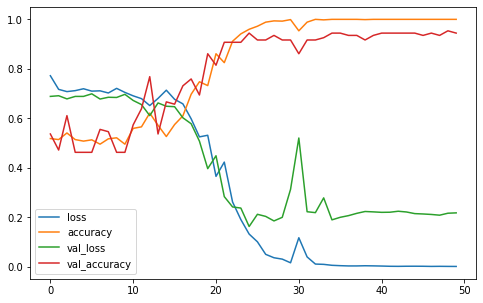

Results for fold 10
Epoch 1/50
16/16 [==============================] - 3s 127ms/step - loss: 0.8230 - accuracy: 0.5144 - val_loss: 0.6991 - val_accuracy: 0.4815
Epoch 2/50
16/16 [==============================] - 2s 107ms/step - loss: 0.7509 - accuracy: 0.5021 - val_loss: 0.6919 - val_accuracy: 0.5000
Epoch 3/50
16/16 [==============================] - 2s 107ms/step - loss: 0.7217 - accuracy: 0.5134 - val_loss: 0.6854 - val_accuracy: 0.5185
Epoch 4/50
16/16 [==============================] - 2s 107ms/step - loss: 0.7105 - accuracy: 0.5391 - val_loss: 0.6788 - val_accuracy: 0.5463
Epoch 5/50
16/16 [==============================] - 2s 108ms/step - loss: 0.7193 - accuracy: 0.5072 - val_loss: 0.6941 - val_accuracy: 0.4815
Epoch 6/50
16/16 [==============================] - 2s 108ms/step - loss: 0.7139 - accuracy: 0.4805 - val_loss: 0.6929 - val_accuracy: 0.4815
Epoch 7/50
16/16 [==============================] - 2s 108ms/step - loss: 0.7125 - accuracy: 0.4918 - val_loss: 0.6906 - val_acc

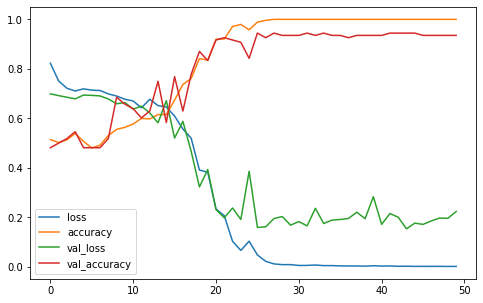

In [16]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9675000071525574
F1_Score  : 0.9672432775295347


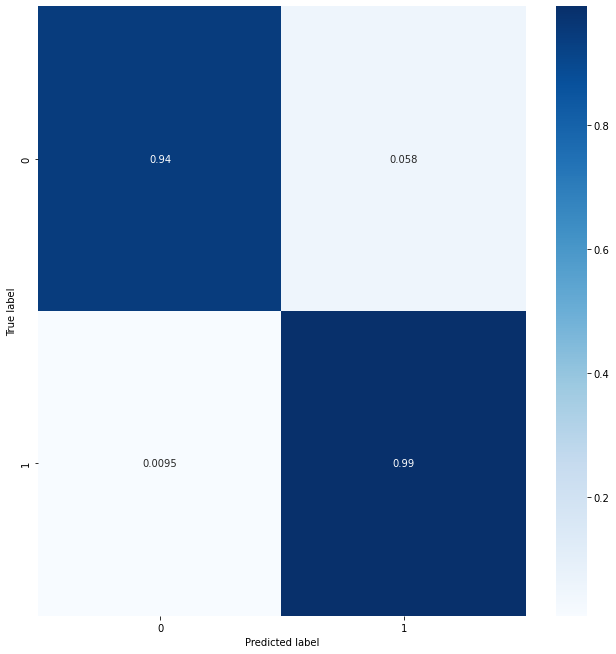

In [17]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()